In [1]:
import pickle
import numpy as np
import re
from utils import clean, split_on_caps, TOP_100_PLAYERS
import pandas as pd
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora

STOPLIST = stopwords.words('english')

import codecs
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [118]:
import numpy as np
import scipy as sp

def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    p = np.asarray(p)
    q = np.asarray(q)
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

## Load Data

In [3]:
docs_cleaned_filename = "docs_cleaned_saturday"
with open (docs_cleaned_filename, 'rb') as fp:
    docs = pickle.load(fp)
    
article_dicts_filename = "article_dicts_saturday"
all_articles = []
with codecs.open(article_dicts_filename,'rU','utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

### Get only alphabetical, and lemmatize

In [5]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return [ps.stem(item) for item in tokens]

In [6]:
lemmatized = [" ".join(tokenize(text)) for text in docs]

### LDA on all the documents

#### Use TF-IDF to identify screen most important words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_screener = TfidfVectorizer(stop_words = 'english', min_df = 0.01, max_df = 0.23)

trans = tfidf_screener.fit_transform(lemmatized)
feats = tfidf_screener.get_feature_names()
vocab = set(tfidf_screener.vocabulary_.keys())

In [8]:
texts = [" ".join([word for word in text.split() if word in vocab]) for text in lemmatized]
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
data_vectorized = vectorizer.fit_transform(texts)

In [14]:
best_lda_model = LatentDirichletAllocation(n_topics=13, learning_decay=0.7)  # have run this multiple times so i know the best estimator...don't want to run grid search again
best_lda_model.fit(data_vectorized)

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

### Cluster Documents that share Similar Topics and Plot

In [133]:
# import numpy as np
# from scipy.cluster.hierarchy import fclusterdata

# fclust1 = fclusterdata(lda_output, , metric=jsd)

In [123]:
# Construct the k-means clusters
from sklearn.cluster import KMeans, AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=10)
clusters = clusterer.fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# # Weights for the 15 columns of lda_output, for each component
# print("Component's weights: \n", np.round(svd_model.components_, 2))
# # Percentage of total information in 'lda_output' explained by the two components
# print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Text(0.5,1,'total sum of squares to centroid vs. number of clusters')

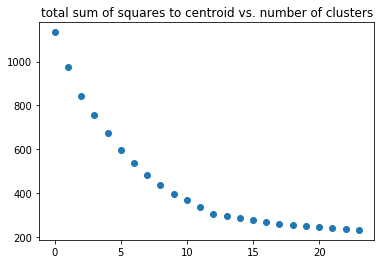

In [101]:
# inertias = []
# for n in range(1, 25):
#     clusterer = KMeans(n_clusters=int(n), random_state=100)
#     clusterer.fit(lda_output)
#     inertias.append(clusterer.inertia_)
    
# plt.scatter([i for i,_ in enumerate(inertias)], inertias)
# plt.title("total sum of squares to centroid vs. number of clusters")

In [103]:
def get_clusters(clusters, docs):
    cluster_dict = {}
    for c in set(clusters):
        cluster_dict[c] = [all_articles[i]['title'] for i,clust in enumerate(clusters) if clust==c]
    return cluster_dict
cluster_dict = get_clusters(clusters, docs)

In [140]:
set(cluster_dict[7][:100]) # 4 and 7 work the best

{'2018 NCAA Tournament Round 2 Saturday Schedule, Game Times Announced',
 '36-Year-Old Accountant Scott Foster Makes NHL Debut as Emergency Goalie',
 "A'ja Wilson, Kelsey Mitchell, Diamond DeShields Comprise Stacked WNBA Draft",
 'After 832 Days Away from the Game, Johnny Football Is Back',
 'Artist Freehand Profit Creates Gas Masks from Rare and Popular Sneakers',
 'B/R x 4/20: A Letter from the Editor',
 'Basketball Meant Life or Death for Marcus Smart',
 'Become the Rory McIlroy of Tailgating with Beer Pong Golf',
 'Blue Jackets Forward Artemi Panarin Has the Cutest Trainer',
 'Butler Earns Lopsided Win over Arkansas in 2018 NCAA Tournament',
 "Cancer Survivor Daniel Jacobs Is Boxing's 'Miracle Man'",
 'Charles Matthews Throws Down Epic Dunk in Loyola-Chicago March Madness Matchup',
 "Conor McGregor Crashed the UFC's Media Day and All Hell Broke Loose",
 "Donte DiVincenzo Named 2018 NCAA Tournament's Most Outstanding Player",
 'Donte DiVincenzo Slams Putback Dunk Home over Texas Tec

In [76]:
# fifteen_clusters = [c for c in clusters]

### Plot the Two SVD Components

Text(0.5,1,'Segregation of Topic Clusters')

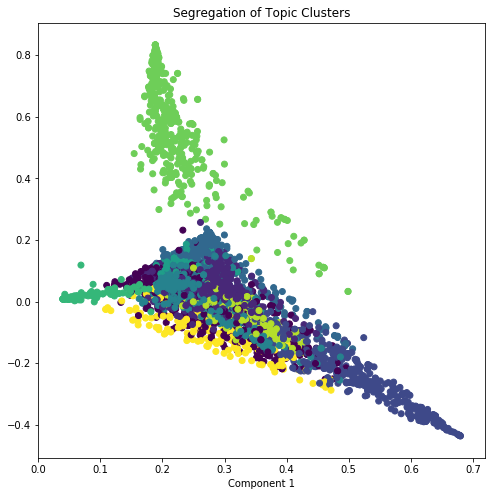

In [147]:
# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

Text(0.5,1,'Segregation of Topic Clusters')

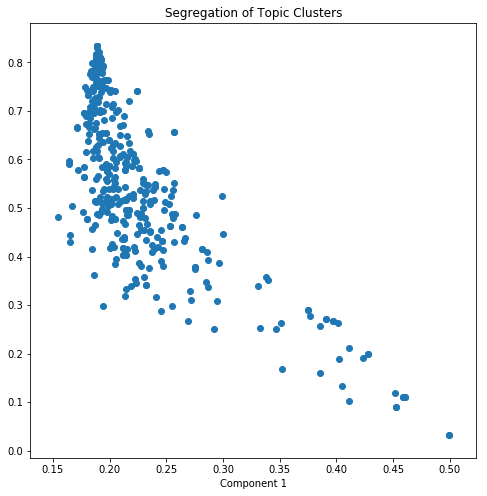

In [148]:
TOPIC = 7
modified_x = [x[i] for i,c in enumerate(clusters) if c==TOPIC]
modified_y = [y[i] for i,c in enumerate(clusters) if c==TOPIC]

plt.figure(figsize=(8,8))
plt.scatter(modified_x, modified_y)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )